# Importing required packages and modules

We use pyspark librarires in addition common python packages from numpy, pandas and scikit learn libararies 

In [1]:
# common imports
import pandas as pd 
import numpy as np
import re

# Visualization imports
np.random.seed(42)
%matplotlib inline
import seaborn as sns
import folium
from folium import plugins
import matplotlib as mpl
import matplotlib.pyplot as plt 
from pprint import pprint
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# modelling imports 
from sklearn.cluster import KMeans
import gensim
from gensim.utils import simple_preprocess
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# pyspark data manipulation imports
from pyspark.context import SparkContext
import pyspark.sql.functions as f
from pyspark.sql.functions import count,col,array,array_join,array_distinct
from pyspark.sql.functions import explode,rank,regexp_replace,split,when,isnan
from pyspark.sql.functions import sum as _sum
from pyspark.sql.window import Window

# pyspark machine learing imports
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import NGram
from pyspark.ml.feature import Word2Vec
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import OneHotEncoder, StringIndexer

In [3]:
# Warning ignorance 
import warnings
warnings.filterwarnings("ignore")
spark.sparkContext.setLogLevel("off")

# Data Acquisition 

We use [yelp](https://www.yelp.com/dataset/documentation/main) dataset. This dataset is a subset of Yelp's businesses, reviews, and user data. There are in total over 8 million reviews, over 160,000 businesses and 200,000 pictures that span across 8 metropolitan areas. It’s in JSON format. We are interested in the main data that doesn’t include photos.


In [4]:
#Loading reviews and users dataset
review_sdf = spark.read.format("json").load("data/yelp_academic_dataset_review.json")
business_sdf = spark.read.format("json").load("data/yelp_academic_dataset_business.json")

In [5]:
# Display reviews dataset
review_sdf.show(5)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|buF9druCkbuXLX526...|   1|2014-10-11 03:34:02|    1|lWC-xP3rd6obsecCY...|  4.0|Apparently Prides...|     3|ak0TdVmGKo4pwqdJS...|
|RA4V8pr014UyUbDvI...|   0|2015-07-03 20:38:25|    0|8bFej1QE5LXp4O05q...|  4.0|This store is pre...|     1|YoVfDbnISlW0f7abN...|
|_sS2LBIGNT5NQb6PD...|   0|2013-05-28 20:38:06|    0|NDhkzczKjLshODbqD...|  5.0|I called WVM on t...|     0|eC5evKn1TWDyHCyQA...|
|0AzLzHfOJgL7ROwhd...|   1|2010-01-08 02:29:15|    1|T5fAqjjFooT4V0OeZ...|  2.0|I've stayed at ma...|     1|SFQ1jcnGguO0LYWnb...|
|8zehGz9jnxPqXtOc7...|   0|2011-07-28 18:05:01|    0|sjm_uUcQVxab_EeLC...|  4.0|The food i

In [6]:
# Display business dataset
business_sdf.show(5)

+-------------------+--------------------+--------------------+--------------------+-----------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+
|            address|          attributes|         business_id|          categories|       city|               hours|is_open|     latitude|      longitude|                name|postal_code|review_count|stars|state|
+-------------------+--------------------+--------------------+--------------------+-----------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+
|       921 Pearl St|{null, null, 'bee...|6iYb2HFDywm3zjuRg...|Gastropubs, Food,...|    Boulder|{11:0-23:0, 11:0-...|      1|   40.0175444|   -105.2833481| Oskar Blues Taproom|      80302|          86|  4.0|   CO|
|7000 NE Airport Way|{null, null, u'be...|tCbdrRPZA0oiIYSmH...|Salad, Soup, Sand...|   Portland|{5:0-18:0, 5:0-18...|      1|45.5889058992|-122.

This dataset has reviews for over 2 million users

In [7]:
# count total number of users 
review_sdf.selectExpr("count(distinct(user_id))").show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                2189457|
+-----------------------+



We choose Boston as a city with high population density and alot of yelp reviews to narrow down the recommended businesses to a single city for better recommendation.

In [8]:
# Selecting a city  
business_sdf.groupBy("city").agg(_sum("review_count").alias('sum')).orderBy(f.col("sum").desc()).show(5)

+--------+-------+
|    city|    sum|
+--------+-------+
|  Austin|1374749|
|Portland|1111989|
| Atlanta| 840503|
|  Boston| 734753|
| Orlando| 647666|
+--------+-------+
only showing top 5 rows



Moreover, we choose resturants because it is the business with most reviews as shown below:

In [9]:
# choosing category with the highest reviews
business_sdf.where("city = 'Boston'").groupBy("categories")\
.agg(_sum("review_count").alias('sum')).orderBy(f.col("sum").desc()).show(10, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------+----+
|categories                                                                                                                                |sum |
+------------------------------------------------------------------------------------------------------------------------------------------+----+
|Candy Stores, Gelato, Food, Coffee & Tea, Restaurants, Desserts, Patisserie/Cake Shop, Specialty Food, Bakeries, Ice Cream & Frozen Yogurt|7298|
|Restaurants, Italian                                                                                                                      |6895|
|Italian, Restaurants                                                                                                                      |6132|
|Arabian, Thai, American (Traditional), Live/Raw Food, Bars, Soup, Nightlife, Seafood, Restaurants                          

In [10]:
# filtering the business dataset to include only categories contain resturant keyword
business_sdf = business_sdf.filter(business_sdf.categories.contains('Restaurants'))

In [11]:
# joining reviews and business dataset by business_id and selecting the required column for our analysis
sdf = review_sdf.join(
      business_sdf,
      review_sdf.business_id == business_sdf.business_id)\
      .where("city = 'Boston'").select("review_id", "user_id",review_sdf['business_id']\
      , "name",'latitude','longitude',"categories","review_count",review_sdf["stars"], "date", "text")

In [12]:
# Display the merged dataset
sdf.toPandas().head()

,review_id,user_id,business_id,name,latitude,longitude,categories,review_count,stars,date,text
0,28gGfkLs3igtjVy61lh77Q,Q8c91v7luItVB0cMFF_mRA,EXOsmAB1s71WePlQk0WZrA,Linwood Grill & BBQ Restaurant,42.342541,-71.099522,Restaurants,14,2.0,2006-04-16 02:58:44,"The setting is perfectly adequate, and the foo..."
1,KKVFopqzcVfcubIBxmIjVA,99RsBrARhhx60UnAC4yDoA,EEHhKSxUvJkoPSzeGKkpVg,Boston Chowda Co,42.348484,-71.082457,"Sandwiches, Seafood, Soup, Restaurants, Fast Food",110,5.0,2014-05-07 18:10:21,I work in the Pru and this is the most afforda...
2,-QpNdU_p44GR0NcRxDRyNQ,ffJp-ZN80M4sSkDL8Ra18w,WDGeeyeK7bG0cvq_ZglAdA,Pearl Villa Seafood Restaurant,42.350670,-71.060962,"Chinese, Restaurants",37,1.0,2009-03-01 01:05:50,Almost desolate restaurant and dingy evironmen...
3,KBBbY9WdKYO_zvXeRxjNKA,LfyHQWb_kFyxbdNFb8kQGA,UAtX7xmIfdd1W2Pebf6NWg,Sidebar Boston,42.356402,-71.060096,"American (Traditional), Bars, Pubs, Nightlife,...",240,1.0,2013-01-02 15:59:38,I think SideBar is the only restaurant downtow...
4,oaCgq_qwWUa7tR9FgBQJqg,UKU5x7fgNWzzdpCh3PqS0A,jhFi0oxdyiyCYK7i-CW59A,Black Seed Cafe & Grill,42.355980,-71.062339,"Sandwiches, Specialty Food, Mediterranean, Cof...",249,4.0,2015-01-03 22:55:27,"Falafel wrap - falafel with greens, pickles, a..."


The number of of user is now 10% of total users after city and category filtering

In [13]:
# count total number of users 
sdf.selectExpr("count(distinct(user_id))").show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                 204454|
+-----------------------+



As reviews are part of our analysis, we select users with more than 10 reviews

In [14]:
# identify users with more than 10 reviews
users = sdf.groupBy("user_id").agg(count("text")).where("count(text) > 10").select("user_id").collect()

In [15]:
# list of these required active users
user_list = [u.user_id for u in users]

In [16]:
# new spark dataframe after filtering users 
sdf = sdf.where(sdf.user_id.isin(user_list))

Active users are only 6578 users which is about 0.32% of Boston users who are using help to find and review resturants.

In [17]:
# count total number of filtered users 
sdf.selectExpr("count(distinct(user_id))").show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                   6578|
+-----------------------+



In [18]:
# Exporting our new filtered dataset for easy processing 
sdf.toPandas().to_csv('yelp_data.csv',index=False)

In [19]:
# importing the dataframe 
data = pd.read_csv('yelp_data.csv')

In [20]:
# showing first rows
data.head()

,review_id,user_id,business_id,name,latitude,longitude,categories,review_count,stars,date,text
0,KBBbY9WdKYO_zvXeRxjNKA,LfyHQWb_kFyxbdNFb8kQGA,UAtX7xmIfdd1W2Pebf6NWg,Sidebar Boston,42.356402,-71.060096,"American (Traditional), Bars, Pubs, Nightlife,...",240,1.0,2013-01-02 15:59:38,I think SideBar is the only restaurant downtow...
1,CSbzdXJe2igJnsW0HveJ6w,_qeS-wNr5HCs8cIxp1-BLQ,4mmKcjlUWF3NTjtgrmBMFQ,Shino Express Sushi,42.350719,-71.077382,"Japanese, Restaurants, Sushi Bars",104,4.0,2010-10-06 00:47:02,This place really hits the spot after a long d...
2,xq1HkKoLzCdOlJkVzUeg5Q,0DmuCPKJ5l4otcf5ar_sew,72PQGMhrEcIuWH-S44TprA,Myers & Chang,42.343819,-71.066250,"Nightlife, Restaurants, Asian Fusion, Vegetari...",1681,4.0,2010-07-07 16:01:03,Still an exceptional restaurant with several n...
3,5S0sOS6OD9RJRYVl5jz7ZA,dUOZB3F9187M8UjbAxTAkQ,Oj5Seggqo_2FfKSjcAg7yw,Empire Asian Restaurant & Lounge,42.352915,-71.045580,"Nightlife, Restaurants, Asian Fusion, Bars, Lo...",536,3.0,2018-05-28 22:25:11,This place is pretty cool! The ambiance has mo...
4,Wm8R5_cFnCfx2aM_wXfDsA,K7DGRGHyyG1Cy-IsKJeP8Q,nzyu4lcjIOH_zPMlaPbmrw,Hot Pot Buffet,42.351373,-71.059852,"Chinese, Buffets, Restaurants, Hot Pot",577,4.0,2010-07-07 16:27:38,"Now, I have written on the subject of shabu sh..."


Boston Resturants data has about 170 thousand reviews

In [21]:
# pandas dataframe shape
data.shape

(170301, 11)

Majority of resturants are getting good rating

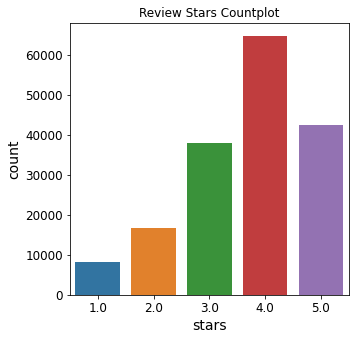

In [22]:
# visualizing rating (stars) distribution 
fig, ax = plt.subplots(figsize=(5,5))
sns.countplot(x = data['stars'], ax=ax)
plt.title('Review Stars Countplot')
plt.savefig('stars.png')
plt.show()

# Kmeans clustering 
Usually users are interested in nearby resturant. That's why we use Kmeans to identify a cluster which has nearby resturants with more reviews than other clusters.

In [23]:
# Elbow method to determine the number of K in Kmeans Clustering
coords = data[['latitude','longitude']]

distortions = []
K = range(1,15)
for k in K:
    kmeansModel = KMeans(n_clusters=k)
    kmeansModel = kmeansModel.fit(coords)
    distortions.append(kmeansModel.inertia_)

We can see from the graph below that 5 clusters are the optimal number for clustering with minmum distortion 

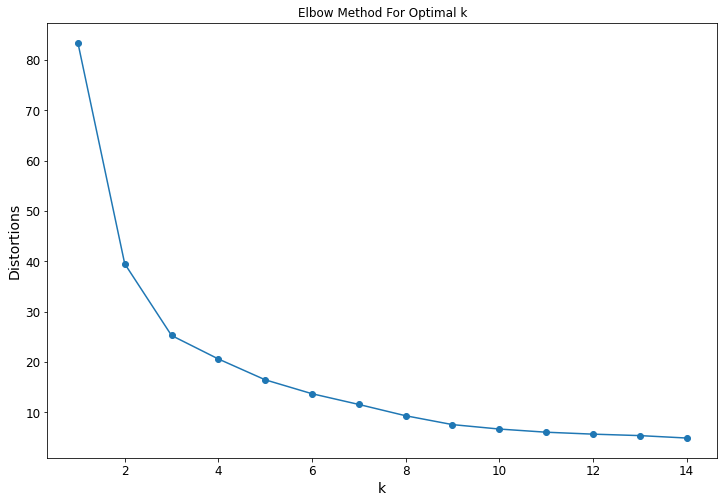

In [24]:
# Elbow visuluization 
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(K, distortions, marker='o')
plt.xlabel('k')
plt.ylabel('Distortions')
plt.title('Elbow Method For Optimal k')
plt.savefig('elbow.png')
plt.show()

In [25]:
# clustering model with k equal to 5
clustering_model = KMeans(n_clusters=5,random_state=42).fit(coords)
data['cluster'] = clustering_model.predict(data[['latitude','longitude']])
data.head()

,review_id,user_id,business_id,name,latitude,longitude,categories,review_count,stars,date,text,cluster
0,KBBbY9WdKYO_zvXeRxjNKA,LfyHQWb_kFyxbdNFb8kQGA,UAtX7xmIfdd1W2Pebf6NWg,Sidebar Boston,42.356402,-71.060096,"American (Traditional), Bars, Pubs, Nightlife,...",240,1.0,2013-01-02 15:59:38,I think SideBar is the only restaurant downtow...,1
1,CSbzdXJe2igJnsW0HveJ6w,_qeS-wNr5HCs8cIxp1-BLQ,4mmKcjlUWF3NTjtgrmBMFQ,Shino Express Sushi,42.350719,-71.077382,"Japanese, Restaurants, Sushi Bars",104,4.0,2010-10-06 00:47:02,This place really hits the spot after a long d...,0
2,xq1HkKoLzCdOlJkVzUeg5Q,0DmuCPKJ5l4otcf5ar_sew,72PQGMhrEcIuWH-S44TprA,Myers & Chang,42.343819,-71.066250,"Nightlife, Restaurants, Asian Fusion, Vegetari...",1681,4.0,2010-07-07 16:01:03,Still an exceptional restaurant with several n...,0
3,5S0sOS6OD9RJRYVl5jz7ZA,dUOZB3F9187M8UjbAxTAkQ,Oj5Seggqo_2FfKSjcAg7yw,Empire Asian Restaurant & Lounge,42.352915,-71.045580,"Nightlife, Restaurants, Asian Fusion, Bars, Lo...",536,3.0,2018-05-28 22:25:11,This place is pretty cool! The ambiance has mo...,3
4,Wm8R5_cFnCfx2aM_wXfDsA,K7DGRGHyyG1Cy-IsKJeP8Q,nzyu4lcjIOH_zPMlaPbmrw,Hot Pot Buffet,42.351373,-71.059852,"Chinese, Buffets, Restaurants, Hot Pot",577,4.0,2010-07-07 16:27:38,"Now, I have written on the subject of shabu sh...",1


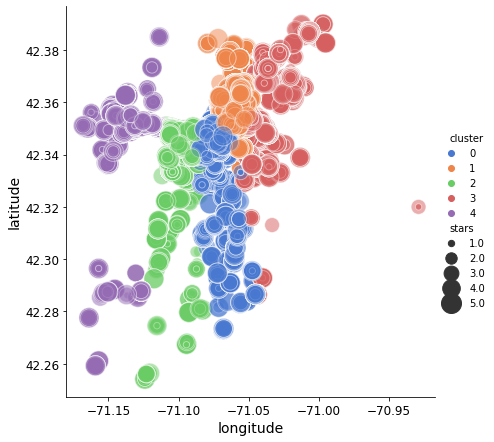

In [26]:
sns.relplot(x="longitude", y="latitude", hue="cluster", size="stars",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=data)
plt.show()

Identifying a cluster with most reviews by visulaizing the reviews distribution in each cluster 

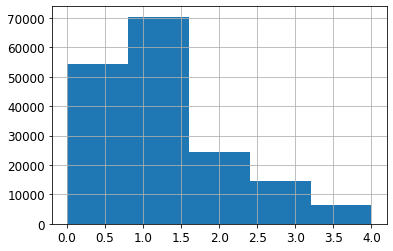

In [27]:
# Determining the cluster with more reviews 
data['cluster'].hist(bins=5)
plt.show()

In [28]:
# First cluster filtering updated data
data_cluster = data[data['cluster']== 1].reset_index(drop = True)

In [29]:
# showing first rows of first cluster data
data_cluster.head()

,review_id,user_id,business_id,name,latitude,longitude,categories,review_count,stars,date,text,cluster
0,KBBbY9WdKYO_zvXeRxjNKA,LfyHQWb_kFyxbdNFb8kQGA,UAtX7xmIfdd1W2Pebf6NWg,Sidebar Boston,42.356402,-71.060096,"American (Traditional), Bars, Pubs, Nightlife,...",240,1.0,2013-01-02 15:59:38,I think SideBar is the only restaurant downtow...,1
1,Wm8R5_cFnCfx2aM_wXfDsA,K7DGRGHyyG1Cy-IsKJeP8Q,nzyu4lcjIOH_zPMlaPbmrw,Hot Pot Buffet,42.351373,-71.059852,"Chinese, Buffets, Restaurants, Hot Pot",577,4.0,2010-07-07 16:27:38,"Now, I have written on the subject of shabu sh...",1
2,_HzC_hxPE5d-zpHZcCkxLg,B2tIcQCyoEq-UpB11-N1JA,oz882XuZCxajKo64Opgq_Q,Barking Crab,42.352606,-71.051660,"Beer Bar, Seafood, Restaurants, Bars, Nightlife",2163,4.0,2013-09-04 03:08:23,The Barking Crab was a family tradition for us...,1
3,Ltk21NKmKW9godxCWw7-1Q,ao4_LR8V8vsEaP6cjL1s_A,VFvCFOYtyK9ae4Skxvf3vA,Saus,42.361080,-71.057072,"Beer Bar, Fast Food, Specialty Food, Food Stan...",1253,4.0,2015-03-18 19:42:13,"I came here after a bruins game, loved it. Pou...",1
4,cSLtFZ7HH-9lZFt9W_QgSw,k8GCH65aHDbClrMcWVBS3A,YCasSG_q_DdhWR6H1nhJ9A,Kaze Shabu Shabu,42.352357,-71.061554,"Restaurants, Hot Pot, Japanese",574,4.0,2008-04-30 02:57:38,In the crazy weather of today (lower 50's with...,1


we have remaining about 70 thousand reviews after choosing cluster 1 

In [30]:
# Cluster 1 shape
data_cluster.shape

(70443, 12)

Our data without null values

In [31]:
# checking if there are null values
data_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70443 entries, 0 to 70442
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   review_id     70443 non-null  object 
 1   user_id       70443 non-null  object 
 2   business_id   70443 non-null  object 
 3   name          70443 non-null  object 
 4   latitude      70443 non-null  float64
 5   longitude     70443 non-null  float64
 6   categories    70443 non-null  object 
 7   review_count  70443 non-null  int64  
 8   stars         70443 non-null  float64
 9   date          70443 non-null  object 
 10  text          70443 non-null  object 
 11  cluster       70443 non-null  int32  
dtypes: float64(3), int32(1), int64(1), object(7)
memory usage: 6.2+ MB


## Resturants further analysis

In [32]:
businesses = data_cluster.groupby('business_id').mean()

In [33]:
businesses.head()

,latitude,longitude,review_count,stars,cluster
business_id,,,,,
-0Gbsd7ztvTyFpl7jF0DIw,42.357737,-71.059351,76.0,3.926829,1.0
-2hT_nT_uny6zqtjcpFFEA,42.349349,-71.061267,42.0,4.148148,1.0
-68H1PxpVbAKiIoYjjW1fQ,42.357137,-71.060993,79.0,2.562500,1.0
-CxbIm-SqwKhXwpKV5s_uQ,42.361013,-71.063960,17.0,2.230769,1.0
-D1qTCXdH5JnbHn53j1TYA,42.348133,-71.062521,9.0,3.800000,1.0


We have remaining more than one thousand resturant

In [34]:
businesses.shape

(1127, 5)

Looking for any correlation between the numerical values

In [35]:
#Checking the correlation
correlation = businesses[['latitude','longitude','review_count', 'stars']].corr()

From the graph below, resturants with more review counts are having better rating

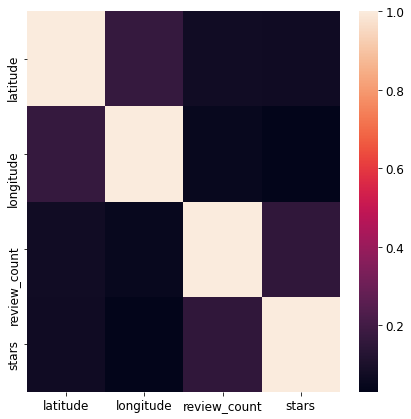

In [36]:
# correlation visualization 
fig,ax = plt.subplots(figsize=(7,7))
sns.heatmap(correlation,ax=ax)
plt.show()

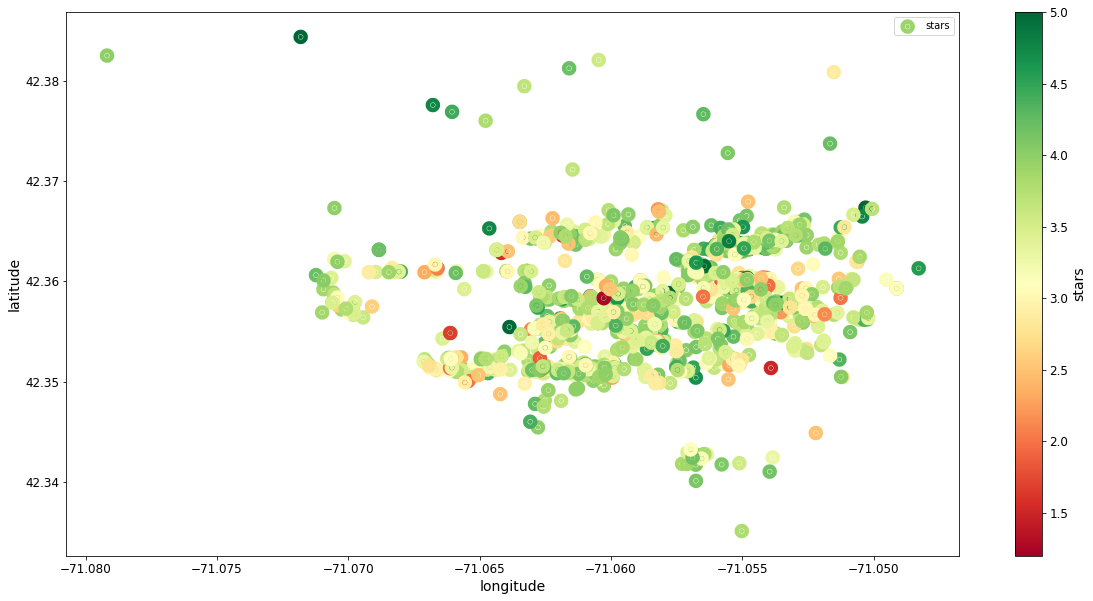

In [37]:
# visualizing resturants distribution 
businesses.plot(kind="scatter", x="longitude", y="latitude",
    label="stars", figsize=(20,10),c="stars", cmap=plt.get_cmap("RdYlGn"), colorbar=True,linewidths=10,
    sharex=False)
plt.legend()
plt.show()

There are some gaps because of hill, river and Tunnel as showing in the below map

In [38]:
# identifying the gaps reasons
m = folium.Map(
    location=[42.36, -71.065],
    zoom_start=14
)
locationlist = businesses[['latitude','longitude']].values.tolist()   
m.add_child(plugins.HeatMap(locationlist, radius=15))
m

# Resturant categories Topic modelling using Latent Dirichlet allocation (LDA)

We use LDA for better profiling the user by identifiying which set of resturant categories he is interested. We converte Boston cluster 927 returant categories to 9 topics.

In [39]:
len(data_cluster['categories'].unique())

927

In [40]:
#Categories Text processing 
# Remove punctuation
data_cluster['categories'] = data_cluster['categories'].map(lambda x: re.sub('[,\.!?())]', '', x))
# convert to lower case letters
data_cluster['categories'] = data_cluster['categories'].map(lambda x: x.lower())
data_cluster['categories'].head()

0    american traditional bars pubs nightlife dive ...
1                  chinese buffets restaurants hot pot
2          beer bar seafood restaurants bars nightlife
3    beer bar fast food specialty food food stands ...
4                         restaurants hot pot japanese
Name: categories, dtype: object

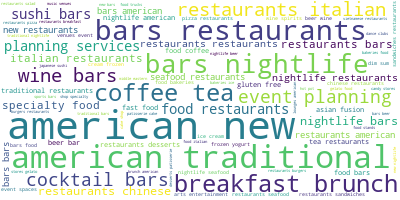

In [41]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(data_cluster['categories'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [42]:
# tokenization 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
x = data_cluster['categories'].values.tolist()
data_words = list(sent_to_words(x))
print(data_words[:1][0][:])

['american', 'traditional', 'bars', 'pubs', 'nightlife', 'dive', 'bars', 'restaurants']


In [43]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:])

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]


In [44]:
# number of topics
num_topics = 9

# build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,random_state = 40, id2word=id2word,num_topics=num_topics)
                                
# print the 9 topic keywords
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.115*"restaurants" + 0.100*"american" + 0.070*"brunch" + 0.070*"breakfast" '
  '+ 0.052*"bars" + 0.052*"traditional" + 0.051*"new" + 0.048*"event" + '
  '0.046*"services" + 0.045*"planning"'),
 (1,
  '0.272*"food" + 0.105*"restaurants" + 0.060*"specialty" + 0.057*"sandwiches" '
  '+ 0.037*"tea" + 0.031*"coffee" + 0.028*"bakeries" + 0.021*"fast" + '
  '0.018*"cafes" + 0.017*"trucks"'),
 (2,
  '0.205*"restaurants" + 0.114*"chinese" + 0.090*"japanese" + 0.053*"sushi" + '
  '0.050*"bars" + 0.041*"noodles" + 0.040*"hot" + 0.038*"shop" + 0.038*"pot" + '
  '0.034*"vietnamese"'),
 (3,
  '0.197*"bars" + 0.138*"nightlife" + 0.135*"restaurants" + 0.113*"american" + '
  '0.083*"new" + 0.067*"lounges" + 0.036*"pubs" + 0.032*"tapas" + '
  '0.025*"small" + 0.025*"plates"'),
 (4,
  '0.113*"bars" + 0.085*"restaurants" + 0.074*"nightlife" + 0.062*"american" + '
  '0.055*"traditional" + 0.049*"event" + 0.041*"pubs" + 0.040*"venues" + '
  '0.033*"entertainment" + 0.033*"hotels"'),
 (5,
  '0.141*"

In [45]:
# adding the topics to our data frame
cat_topic = []
for item in doc_lda:
    T= []
    for i in item:
        T.append(i[1])
    t = T.index(max(T))
    cat_topic.append(t)
data_cluster['topic'] = cat_topic

Identifying the topic with most reveiws for modelling and recommending resturants for it's users

In [46]:
# Display number of reviews for each user across topics
data_cluster['topic'] = data_cluster['topic'].astype('object')
user_id__topic = pd.crosstab(data_cluster["user_id"],data_cluster["topic"])
user_id__topic.head()

topic,0,1,2,3,4,5,6,7,8
user_id,,,,,,,,,
-05Qe5nEy9twR49Q7rwuxw,0,1,0,2,0,0,3,1,0
-0ryDHRHIl3n6_NHvgF17g,6,1,3,3,0,1,3,2,2
-2ppiuB9YEULS4z3lC5g-Q,1,2,0,0,0,1,4,0,4
-3k65IY08ckDcOGQmf8BDg,12,4,3,25,7,2,24,5,4
-3qt2Mxn-rmy4QHbTWUk-g,2,1,1,2,1,1,1,0,1


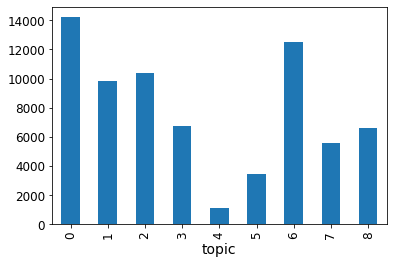

In [47]:
# Visulaization for reviews count per user per topic
user_id__topic.sum().plot(kind = 'bar')
plt.show()

There is high corrlation specially between topic 0 users which has the most reviews and topics 3 & 6. In Fact, some people tends to try resturants from different kitchens. That's why we will select topic 0 which is tradional american breakfast and brunch

In [48]:
cm = sns.light_palette("green", as_cmap=True)
user_id__topic.corr().style.background_gradient(cmap=cm)

topic,0,1,2,3,4,5,6,7,8
topic,,,,,,,,,
0,1.000000,0.659107,0.519889,0.650867,0.395249,0.551312,0.684226,0.400356,0.508253
1,0.659107,1.000000,0.637860,0.443485,0.269031,0.541413,0.510947,0.503294,0.581649
2,0.519889,0.637860,1.000000,0.402353,0.205012,0.511994,0.427448,0.642563,0.558308
3,0.650867,0.443485,0.402353,1.000000,0.396617,0.424969,0.607623,0.333149,0.359323
4,0.395249,0.269031,0.205012,0.396617,1.000000,0.204148,0.347179,0.163366,0.207687
5,0.551312,0.541413,0.511994,0.424969,0.204148,1.000000,0.459790,0.387699,0.420916
6,0.684226,0.510947,0.427448,0.607623,0.347179,0.459790,1.000000,0.348850,0.464539
7,0.400356,0.503294,0.642563,0.333149,0.163366,0.387699,0.348850,1.000000,0.506962
8,0.508253,0.581649,0.558308,0.359323,0.207687,0.420916,0.464539,0.506962,1.000000


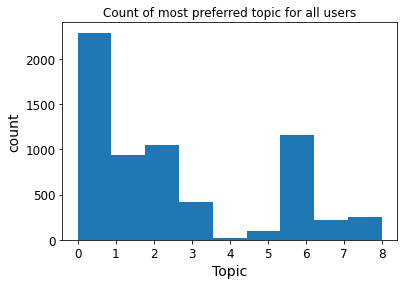

In [49]:
# visulaizing the topic with most choice per user
user_id__topic.idxmax(axis=1).hist(bins=9, grid=False)
plt.xlabel('Topic')
plt.ylabel('count')
plt.title('Count of most preferred topic for all users')
plt.show()

Topic 0 is the most preferred topic across all users 

In [50]:
# confirming businesss are under the same topic as shown in the below table.
business_id__topic = pd.crosstab(data_cluster["business_id"],data_cluster["topic"])
business_id__topic.head(10)

topic,0,1,2,3,4,5,6,7,8
business_id,,,,,,,,,
-0Gbsd7ztvTyFpl7jF0DIw,0,41,0,0,0,0,0,0,0
-2hT_nT_uny6zqtjcpFFEA,0,27,0,0,0,0,0,0,0
-68H1PxpVbAKiIoYjjW1fQ,0,16,0,0,0,0,0,0,0
-CxbIm-SqwKhXwpKV5s_uQ,0,13,0,0,0,0,0,0,0
-D1qTCXdH5JnbHn53j1TYA,0,5,0,0,0,0,0,0,0
-GWlNWi0FL6ZyMJyDDa40Q,0,0,10,0,0,0,0,0,0
-Gyr3VSDQnqzdzg-Iv228Q,0,64,0,0,0,0,0,0,0
-Ly-ExWbYvrVoVYHsSowSw,0,0,14,0,0,0,0,0,0
-S_m_GBqkGEjABeO0FaxzA,104,0,0,0,0,0,0,0,0


In [51]:
# choosing topics 0
data_cluster_topic = data_cluster[data_cluster['topic'].isin([0])]

In [52]:
len(data_cluster_topic['business_id'].unique())

200

Topic 0 has total 200 unique resturants which we requires to choose 10,20,30 resturants from them to recommend to user and evaluate if any of these resturants are actually visited by the user.

# Collaborative filtering (CF)

We train explicit Alternating Least Square (ALS) model usig pyspark . We evaluate the recommendation model by measuring the root-mean-square error of rating prediction then evaluate actual resturants visited by users by measuring Percision, Recall and F1 Score 

In [53]:
#Converting pandas dataframe to pyspark data frame
sdf = spark.createDataFrame(data_cluster_topic)

In [54]:
# Converting user_id and business_d to indexs according to model input requirements
userIdIndexer = StringIndexer(inputCol="user_id", outputCol="user_id_index")
usermodel = userIdIndexer.setHandleInvalid("skip").fit(sdf)
user_index = usermodel.transform(sdf)

businessIdIndexer = StringIndexer(inputCol="business_id", outputCol="business_id_index")
businessmodel = businessIdIndexer.setHandleInvalid("skip").fit(user_index)
business_index = businessmodel.transform(user_index)

df = business_index.select("user_id_index","business_id_index","text","stars")

In [55]:
df.show(5)

+-------------+-----------------+--------------------+-----+
|user_id_index|business_id_index|                text|stars|
+-------------+-----------------+--------------------+-----+
|        120.0|              1.0|I came here after...|  4.0|
|         66.0|             21.0|The best $7 you w...|  5.0|
|       4129.0|             69.0|I have had lunch ...|  3.0|
|       3167.0|             69.0|I was in the card...|  4.0|
|       2910.0|             66.0|Their menu is pre...|  4.0|
+-------------+-----------------+--------------------+-----+
only showing top 5 rows



The above table shows our indexed user_id and business_id as input requirements to the ALS CF algorithm

In [56]:
# splitting the clustered topic data to 70% train and 30% test 
DF = df.cache()
train,test = DF.randomSplit(weights = [0.7, 0.3], seed = 42)

In [57]:
train.show(5)

+-------------+-----------------+--------------------+-----+
|user_id_index|business_id_index|                text|stars|
+-------------+-----------------+--------------------+-----+
|          0.0|              1.0|*** 4/2018 lunch ...|  3.0|
|          0.0|              1.0|I'm surprised tha...|  3.0|
|          0.0|              3.0|Why in the world ...|  4.0|
|          0.0|             12.0|When we arrived f...|  3.0|
|          0.0|             21.0|Boy, I'm full.  $...|  4.0|
+-------------+-----------------+--------------------+-----+
only showing top 5 rows



In [58]:
test.show(5)

+-------------+-----------------+--------------------+-----+
|user_id_index|business_id_index|                text|stars|
+-------------+-----------------+--------------------+-----+
|          0.0|              1.0|This is a rather ...|  3.0|
|          0.0|             28.0|With Groupon in h...|  3.0|
|          0.0|             31.0|So for my sole Re...|  3.0|
|          0.0|             37.0|A voucher brought...|  4.0|
|          0.0|             48.0|An App was offeri...|  4.0|
+-------------+-----------------+--------------------+-----+
only showing top 5 rows



We can see same user ID in train and test data across different businesses as it is ALS CF can't make predictions on unseed user IDs

In [59]:
#  cold start strategy to 'drop' to avoid getting NaN evaluation metrics
als = ALS(maxIter=5, regParam=0.1, userCol="user_id_index", itemCol="business_id_index", ratingCol="stars",
          coldStartStrategy="drop")
model_als = als.fit(train)

# RMSE evaluation
prediction = model_als.transform(test)
reg_eval = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")
rmse = reg_eval.evaluate(prediction)
print("RMSE = " + str(rmse))

RMSE = 2.118195326206953


In [60]:
# Tuning model
# defining optimization hyperparameters
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [30,100,300]) \
            .addGrid(als.regParam, [0.03,0.1,0.3]) \
            .build()
# constructing the rmse evaluator
tuned_reg_eval = RegressionEvaluator(
           metricName="rmse", 
           labelCol="stars", 
           predictionCol="prediction") 
# Building 5-Fold cross validation
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=tuned_reg_eval, numFolds=5)
tuned_model_als = cv.fit(train)
# Extracting the best model
best_model = tuned_model_als.bestModel
# Tuned RMSE evaluation
tuned_pred = best_model.transform(test)
tuned_rmse =tuned_reg_eval.evaluate(tuned_pred)
print("Tuned_RMSE = " + str(tuned_rmse))

Tuned_RMSE = 1.3571651469507455


From above training, our tuned best model with 5-Fold cross validation has much better RMSE 

In [61]:
# Finding top 10,20,30 recommendations for testing users
users = test.select(als.getUserCol()).distinct()
Rs1 = best_model.recommendForUserSubset(users, 10)
Rs2 = best_model.recommendForUserSubset(users, 20)
Rs3 = best_model.recommendForUserSubset(users, 30)

In [62]:
#Showing the best 10 recommended resturants for users by rating
Rs1.show(5,truncate=False)

+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id_index|recommendations                                                                                                                                                              |
+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1580         |[{123, 4.9214306}, {92, 4.9065914}, {24, 4.8479576}, {36, 4.7368016}, {133, 4.7263207}, {22, 4.6954746}, {8, 4.6418953}, {13, 4.6222568}, {178, 4.6192245}, {105, 4.5961356}]|
|2122         |[{92, 3.7726033}, {0, 3.6867225}, {133, 3.6612005}, {161, 3.6086133}, {36, 3.5961888}, {24, 3.5502322}, {178, 3.542769}, {153, 3.531054}, {13, 3.5144897}, {123, 3.4870307}] |
|2142         |[{161, 1.8467473}, {133, 1.8432412}

In [63]:
#merging orignal test and recommended resturants
test_array = test.groupBy("user_id_index").agg(f.collect_list("business_id_index").alias("business_id_test"))
testb = test_array.toPandas()
def rec_function(Rs):
    rec_array = Rs.select(col("user_id_index"),explode(col('recommendations'))).groupBy("user_id_index")\
    .agg(f.collect_list("col.business_id_index").alias("business_id_rec"))
    rec = rec_array.toPandas()
    return rec
rec1 = rec_function(Rs1)
rec2 = rec_function(Rs2)
rec3 = rec_function(Rs3)
test_rec1 = pd.merge(testb,rec1)
test_rec2 = pd.merge(testb,rec2)
test_rec3 = pd.merge(testb,rec3)

In [64]:
# Displaying test and recommend businesess datframe
test_rec3.head()

,user_id_index,business_id_test,business_id_rec
0,299.0,"[1.0, 5.0, 104.0]","[178, 133, 92, 169, 183, 13, 154, 56, 36, 110,..."
1,558.0,"[1.0, 47.0]","[41, 154, 183, 20, 164, 178, 133, 24, 47, 105,..."
2,1761.0,"[1.0, 121.0]","[16, 133, 178, 154, 56, 92, 10, 161, 13, 3, 10..."
3,2815.0,[3.0],"[68, 36, 161, 31, 24, 137, 154, 178, 92, 19, 1..."
4,496.0,"[7.0, 9.0]","[178, 92, 56, 133, 161, 12, 153, 108, 24, 154,..."


In [65]:
# Recommendation evaluation function 
def recommendation_evaluation(df_rec, r):
    true_recommend = []
    test_users_names = []
    P = []
    K = []
    for i in range(df_rec.shape[0]):
        t = np.isin(df_rec.iloc[i,1],df_rec.iloc[i,2]).sum()
        true_recommend.append(t)
        test_users_names.append(len(df_rec.iloc[i,1]))
        P.append(t/r) 
        K.append(t/len(df_rec.iloc[i,1]))
    precision = round((1/df_rec.shape[0])*np.sum(P),3)
    recall = round((1/df_rec.shape[0])*np.sum(K),3)
    F1Score = round(2*precision*recall/(precision+recall),3)
    return  precision,recall,F1Score

In [66]:
print("precision, recall, F1Score for 10 best Recommends for CF Approach " ,recommendation_evaluation(test_rec1,10))
print("precision, recall, F1Score for 20 best Recommends for CF Approach " ,recommendation_evaluation(test_rec2,20))
print("precision, recall, F1Score for 30 best Recommends for CF Approach " ,recommendation_evaluation(test_rec3,30))

precision, recall, F1Score for 10 best Recommends for CF Approach  (0.016, 0.094, 0.027)
precision, recall, F1Score for 20 best Recommends for CF Approach  (0.016, 0.192, 0.03)
precision, recall, F1Score for 30 best Recommends for CF Approach  (0.016, 0.287, 0.03)


In [67]:
# assigning best 10,20,30 recommendations of collabrative filtering to variables
re1,re2,re3 = recommendation_evaluation(test_rec1,10),recommendation_evaluation(test_rec2,20),\
              recommendation_evaluation(test_rec3,30)

# Reviews Vecorization and Cosine Similarity (CS) (Our Approach)

We use pyspark word2vec models to convert review text words to vectors which in turn we can use it as input to find the similarity between user reviews and resturant reviews and hence recommend highest similar resturants.

Before Vectorization, we need to do some text processing. Starting by tokenizatio, then remove stop words and finally ranking most common 2nd gram for user and resturants.

In [68]:
# review (preferences) tokenizer 
rev_tok = RegexTokenizer(inputCol="text", outputCol="words",gaps = False,pattern = "\\b[a-zA-Z]+\\b")

In [69]:
# list of reviews to enrich stopwords
text_col = train.select("text").collect()
text_list = [t.text for t in text_col]

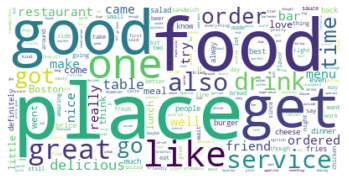

In [70]:
# concatenate all the reviews into one single string 
full_text = ' '.join(text_list)
stopwordList = StopWordsRemover().getStopWords()
cloud_no_stopword = WordCloud(background_color='white', stopwords=stopwordList).generate(full_text)
plt.imshow(cloud_no_stopword, interpolation='bilinear')
plt.axis('off')
plt.show()

From the above word cloud, we can see some key words that can added to our stop words list like also,go,etc

In [71]:
# Most used words
words_freq = pd.Series(WordCloud(stopwords=stopwordList).process_text(full_text)).sort_values(ascending=False)[:20]

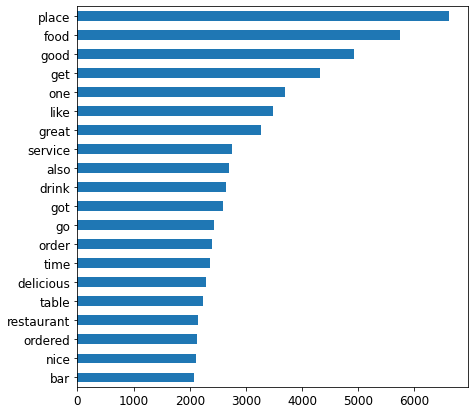

In [72]:
# Word distribution visulaiztion 
words_freq.sort_values().plot(kind='barh', figsize=(7, 7))
plt.show()

From the above word frequency distribution, we can see some key words that can added to our stop words list like also,go,etc

In [73]:
# updating stop words corpus by not useful resturant identifer words
stopwordList = ["get","one","also","got","go","really"]
stopwordList.extend(StopWordsRemover().getStopWords())

In [74]:
# stop words preference removal
rev_rmvr = StopWordsRemover(inputCol=rev_tok.getOutputCol(), outputCol="filtered", stopWords = stopwordList)

In [75]:
# ngrams for preferences; considering using bigram
ngram = NGram(n=2, inputCol=rev_rmvr.getOutputCol(), outputCol="ngrams")

In [76]:
# train user preferences pipelining
pipeline = Pipeline(stages=[rev_tok,rev_rmvr,ngram])
ngram_train =  pipeline.fit(train).transform(train)

In [77]:
# test item preferences pipelining
pipeline = Pipeline(stages=[rev_tok,rev_rmvr,ngram])
ngram_test =  pipeline.fit(test).transform(test)

In [78]:
# training user profile preferences extraction; extracting the most common 1000 features for each item from item reviews
ngram_df = ngram_train.withColumn("ngrams",explode(ngram_train.ngrams)).select("user_id_index","ngrams")
user_pref_train = ngram_df.groupby("user_id_index","ngrams").agg(count("ngrams").alias("frequency"))
windowngram = Window.partitionBy("user_id_index").orderBy(col("frequency").desc())
user_pref_train = user_pref_train.select('*', rank().over(windowngram).alias('rank')).filter(col("rank") <= 1000)
user_pref_train = user_pref_train.groupby("user_id_index").agg(f.concat_ws(", ", f.collect_list(user_pref_train.ngrams)).alias("preferences"))\
                    .withColumn("preferences",split(col("preferences"), ","))

In [79]:
# testing item preferences extraction; extracting the most common 1000 features for each item from item reviews
ngram_df = ngram_test.withColumn("ngrams",explode(ngram_test.ngrams)).select("business_id_index","ngrams")
item_pref_test = ngram_df.groupby("business_id_index","ngrams").agg(count("ngrams").alias("frequency"))
windowngram = Window.partitionBy("business_id_index").orderBy(col("frequency").desc())
item_pref_test = item_pref_test.select('*', rank().over(windowngram).alias('rank')).where(col("rank") <= 1000)
item_pref_test = item_pref_test.groupby("business_id_index").agg(f.concat_ws(", ", f.collect_list(item_pref_test.ngrams)).alias("preferences"))\
                    .withColumn("preferences",split(col("preferences"), ","))

In [80]:
#Showing user train preferences
user_pref_train.show(5)

+-------------+--------------------+
|user_id_index|         preferences|
+-------------+--------------------+
|        299.0|[paid multiple,  ...|
|        305.0|[pomegranate juic...|
|        496.0|[come back,  rest...|
|        558.0|[food truck,  ano...|
|        596.0|[problem service,...|
+-------------+--------------------+
only showing top 5 rows



In [81]:
# showing item test preferences
item_pref_test.show(5)

+-----------------+--------------------+
|business_id_index|         preferences|
+-----------------+--------------------+
|            147.0|[wedding receptio...|
|            170.0|[size arm,  add g...|
|            184.0|[umass club,  tri...|
|            160.0|[breakfast sandwi...|
|            169.0|[lentil soup,  so...|
+-----------------+--------------------+
only showing top 5 rows



In [82]:
# preferences vectorization on user training pref with vector dim=1000
vec_pref = Word2Vec(vectorSize=1000, inputCol="preferences", outputCol="pref_features")
model_user_pref = vec_pref.fit(user_pref_train)
train_user_pref_features = model_user_pref.transform(user_pref_train)
test_item_pref_features = model_user_pref.transform(item_pref_test)
train_user_pref_features  = train_user_pref_features.toPandas()
test_item_pref_features = test_item_pref_features.toPandas()

In [83]:
# showing trained user vectorized preferences
train_user_pref_features.head()

,user_id_index,preferences,pref_features
0,299.0,"[paid multiple, saturdays usually, multiple ...","[0.003222008150481581, -0.0006403102911815453,..."
1,305.0,"[pomegranate juice, completely different, pr...","[0.001473044803880727, -0.0003065013416151965,..."
2,496.0,"[come back, restaurant week, coconut curry, ...","[0.0029569877386521333, -0.0006033237553509381..."
3,558.0,"[food truck, another minutes, ordered drinks...","[0.00227960812553647, -0.0004659258229783821, ..."
4,596.0,"[problem service, recently noticed, guys act...","[0.002036801306800313, -0.00043322093269024557..."


In [84]:
# cosine similarity between train user vectors and test item vectors
cosine_sim = cosine_similarity(np.array(train_user_pref_features['pref_features'].to_list()), \
                               np.array(test_item_pref_features['pref_features'].to_list()))

In [85]:
# test businesses from splitting 
test_array = test.groupBy("user_id_index").agg(f.collect_list("business_id_index").alias("business_id_test"))
testb = test_array.toPandas()

In [86]:
# Function to extract recommend resturants ids
def rec_cos(r):
    Ind = (-cosine_sim).argsort(axis=1)[:,:r]
    rec = pd.DataFrame(data = Ind)
    rec = pd.DataFrame(rec.apply(lambda x : [str(test_item_pref_features['business_id_index'][j]) for j in x]).agg(','.join, axis=1))
    rec = rec.rename(columns={0:'business_id_rec'})
    rec['business_id_rec'] = rec['business_id_rec'].str.split(',')
    return rec

In [87]:
# mergeing recommended resturants from cosine similarity and test resturants 
rec10 = rec_cos(10)
rec20 = rec_cos(20)
rec30 = rec_cos(30)
test_rec10 = pd.concat([testb,rec10],axis = 1).dropna()
test_rec20 = pd.concat([testb,rec20],axis = 1).dropna()
test_rec30 = pd.concat([testb,rec30],axis = 1).dropna()

In [88]:
print("precision, recall, F1Score for 10 best Recommends for CS approach" ,recommendation_evaluation(test_rec10,10))
print("precision, recall, F1Score for 20 best Recommends for CS approach" ,recommendation_evaluation(test_rec20,20))
print("precision, recall, F1Score for 30 best Recommends for CS approach" ,recommendation_evaluation(test_rec30,30))

precision, recall, F1Score for 10 best Recommends for CS approach (0.008, 0.084, 0.015)
precision, recall, F1Score for 20 best Recommends for CS approach (0.019, 0.246, 0.035)
precision, recall, F1Score for 30 best Recommends for CS approach (0.019, 0.364, 0.036)


In [89]:
# assigning best 10,20,30 recommendations of cosine similarity to variables
re10,re20,re30 = recommendation_evaluation(test_rec10,10),recommendation_evaluation(test_rec20,20),\
                recommendation_evaluation(test_rec30,30)

In [90]:
# precision , recall and F1 score for Collabrative Filtering (CF) and Cosine Similarity (CS)
d1 = {'precision_CF': [re1[0],re2[0],re3[0]],'precision_CS': [re10[0],re20[0],re30[0]]}
p = pd.DataFrame(index=['10 best Rs', '20 best Rs','30 best Rs'],data=d1,dtype=float)

d2 = {'recall_CF':[re1[1],re2[1],re3[1]], 'recall_CS':[re10[1],re20[1],re30[1]]}
r = pd.DataFrame(index=['10 best Rs', '20 best Rs','30 best Rs'],data=d2,dtype=float)

d3 = {'F1Score_CF':[re1[2],re2[2],re3[2]],'F1Score_CS':[re10[2],re20[2],re30[2]]}
f1 = pd.DataFrame(index=['10 best Rs', '20 best Rs','30 best Rs'],data=d3,dtype=float)

In [91]:
# Precision Comparison between Collabrative Filtering (CF) and Cosine Similarity (CS)
p

,precision_CF,precision_CS
10 best Rs,0.016,0.008
20 best Rs,0.016,0.019
30 best Rs,0.016,0.019


In [92]:
# Recall Comparison between Collabrative Filtering (CF) and Cosine Similarity (CS)
r

,recall_CF,recall_CS
10 best Rs,0.094,0.084
20 best Rs,0.192,0.246
30 best Rs,0.287,0.364


In [93]:
# F1 Score Comparison between Collabrative Filtering (CF) and Cosine Similarity (CS)
f1

,F1Score_CF,F1Score_CS
10 best Rs,0.027,0.015
20 best Rs,0.030,0.035
30 best Rs,0.030,0.036


### Comparison between performance evaluation for Collabrative Filtering (CF) and Cosine Similarity (CS)

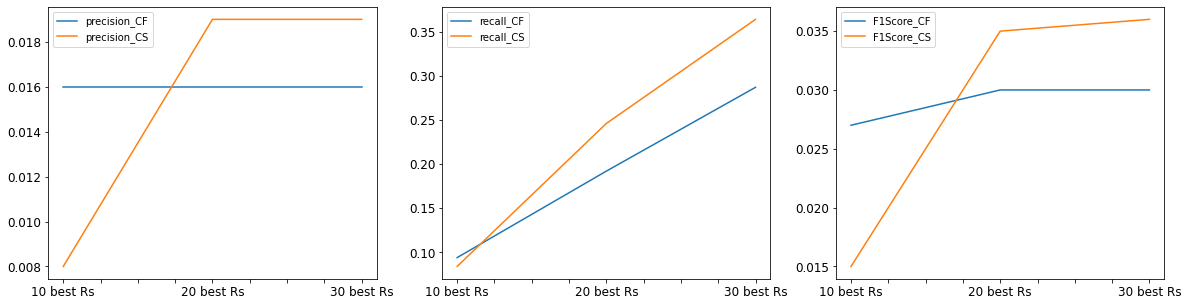

In [94]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20,5))
p.plot(ax=axes[0])
r.plot(ax=axes[1])
f1.plot(ax=axes[2])
plt.show()

# Results
We are to show better performance in 20 and 30 best recommendation to users with only considering text reviews without rating knowledege which is the basis for collabrative filtering. Recall measurements are better than precision and F1 score. 




# Conclusion

User profiling by locating living city, products of interests, nearby products and range of preferred categories(Topics) in addition to user text which can be review or social networking communication could help for better personalized recommendations. 